# Debug Test Script EnergyDiff

In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import torch
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import pandas as pd

from src.opensynth.data_modules.lcl_data_module import LCLDataModule, LCLData
from src.opensynth.models.energydiff import diffusion, calibrate

/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LCLDataModuleWithValidation(LCLDataModule):
    def __init__(self, data_path, stats_path, batch_size=32, n_samples=1000, outlier_path=None, n_val_samples=200):
        super().__init__(data_path, stats_path, batch_size, n_samples, outlier_path=outlier_path)
        self.n_val_samples = n_val_samples

    def setup(self, stage=None):
        super().setup(stage)
        self.val_dataset = LCLData(
            data_path=self.data_path,
            stats_path=self.stats_path,
            n_samples=self.n_val_samples,
            outlier_path=self.outlier_path,
        )
        
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            self.batch_size,
            drop_last=True,
            shuffle=False,
        )
        

In [3]:
# prep data
data_path = Path("data/processed/historical/train/lcl_data.csv")
stats_path = Path("data/processed/historical/train/mean_std.csv")
outlier_path = Path("data/processed/historical/train/outliers.csv")

dm = LCLDataModuleWithValidation(
    data_path=data_path,
    stats_path=stats_path,
    batch_size=200,
    n_samples=2000,
)
dm.setup()

In [4]:
# fake data
def get_noisy_sin(n_samples):
    x = np.linspace(0, 3/2 * np.pi, 48)
    samples = []
    for _ in range(n_samples):
        phase = np.random.uniform(0, 2 * np.pi)
        y = np.sin(x + phase) + np.random.normal(0, 0.01, x.shape)
        samples.append(y)
    return {
        'kwh': torch.from_numpy(np.array(samples)).float(), 
        'features': torch.from_numpy(x).float()
    }
    
class SinDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples=1000):
        self.data = get_noisy_sin(n_samples)
    
    def __len__(self):
        return len(self.data['kwh'])
    
    def __getitem__(self, idx):
        return {
            'kwh': self.data['kwh'][idx],
            'features': self.data['features']
        }

class SinDataModule(pl.LightningDataModule):
    def __init__(self, n_samples=1000, batch_size=32, n_val_samples=0):
        super().__init__()
        self.n_samples = n_samples
        self.n_val_samples = n_val_samples
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SinDataset(self.n_samples)
        self.val_dataset = SinDataset(self.n_val_samples)

    def train_dataloader(self):
        dataset = self.train_dataset
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        dataset = self.val_dataset
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size)


In [5]:
# dm = SinDataModule(n_samples=1000, batch_size=200, n_val_samples=600)
# dm.setup()

In [4]:
# prep model
df_model = diffusion.PLDiffusion1D(
    dim_base=128,
    dim_in=1,
    num_attn_head=4,
    num_decoder_layer=12,
    dim_feedforward=512,
    dropout=0.1,
    learn_variance=False,
    num_timestep=1000,
    model_mean_type=diffusion.ModelMeanType.V,
    model_variance_type=diffusion.ModelVarianceType.FIXED_SMALL,
    loss_type=diffusion.LossType.MSE,
    beta_schedule_type=diffusion.BetaScheduleType.COSINE,
    lr=1e-3,
    ema_update_every=1,
    ema_decay=0.999,
)
trainer = pl.Trainer(
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    max_epochs=250,
    accelerator="cpu",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
# df_model = diffusion.PLDiffusion1D.load_from_checkpoint('lightning_logs/version_35/checkpoints/epoch=499-step=5000.ckpt',)

In [5]:
# training
trainer.fit(df_model, dm,
            # ckpt_path='lightning_logs/version_35/checkpoints/epoch=499-step=5000.ckpt', # optional. ALSO resumes the model, along with training state
            )


  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | diffusion_model | GaussianDiffusion1D | 3.7 M  | train
1 | ema             | EMA                 | 7.4 M  | train
----------------------------------------------------------------
3.7 M     Trainable params
3.7 M     Non-trainable params
7.4 M     Total params
29.598    Total estimated model params size (MB)
619       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:368: You have overridden `on_before_batch_transfer` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 11:  30%|███       | 3/10 [00:05<00:11,  0.59it/s, v_num=47, train_loss_step=0.412, train_loss_epoch=0.529] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [6]:
log_dir = trainer.logger.log_dir
metrics = pd.read_csv(f"{log_dir}/metrics.csv")
epoch_train_loss = metrics['train_loss_epoch'].dropna().values
epoch_val_loss = metrics['val_loss'].dropna().values

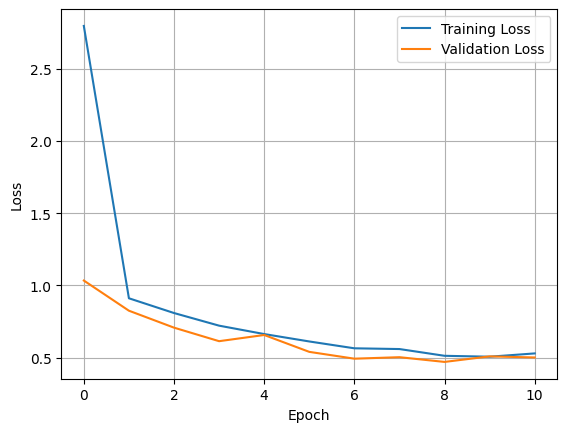

In [7]:
plt.plot(epoch_train_loss, label='Training Loss')
plt.plot(epoch_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# sample
ema_df_model = df_model.ema.ema_model # GaussianDiffusion1D
ans_samples = ema_df_model.ancestral_sample(50, 50, 48, 1)
dpm_samples = ema_df_model.dpm_solver_sample(50, 50, 100, (48, 1))
true_samples = dm.dataset[0:50]['kwh']

sampling batch 1/1, batch size 50. 


Sampling Loop Timestep: 100%|██████████| 1000/1000 [02:21<00:00,  7.07it/s]


sampling batch 1/1, batch size 50. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]


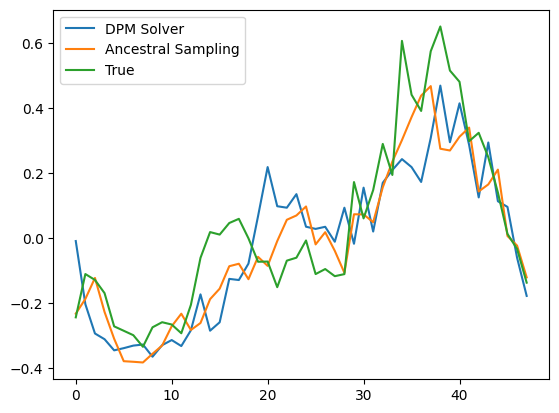

In [9]:
plt.plot(dpm_samples.mean(dim=0).cpu().numpy(), label='DPM Solver')
plt.plot(ans_samples.mean(dim=0).cpu().numpy(), label='Ancestral Sampling')
plt.plot(true_samples.mean(dim=0).cpu().numpy(), label='True')
plt.legend()
plt.show()

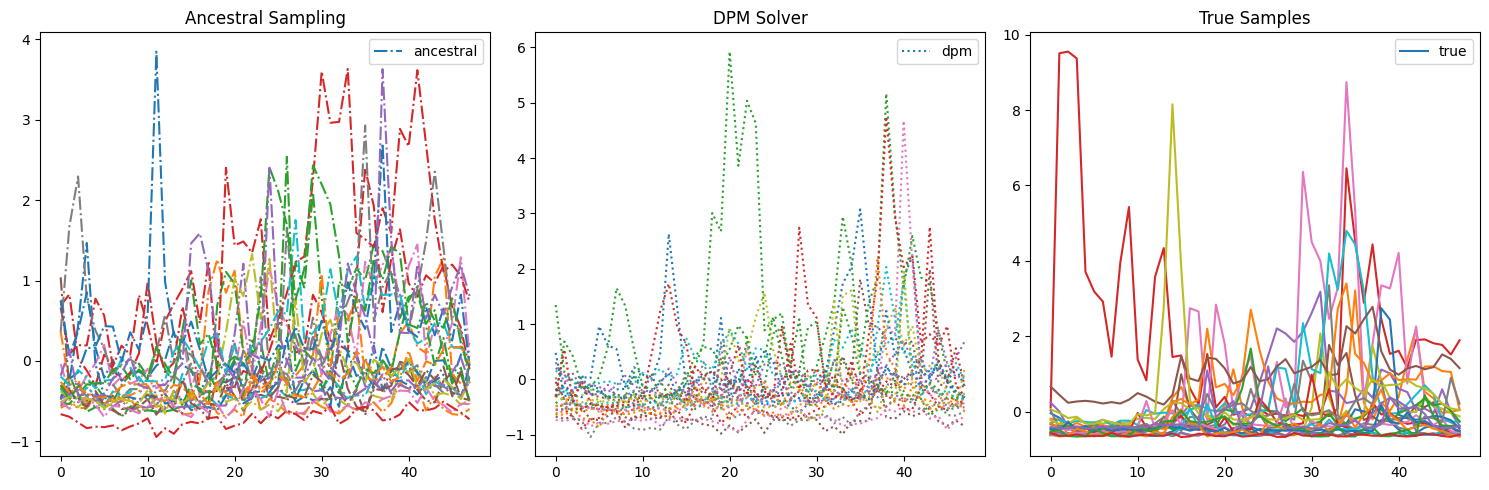

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx in range(min(ans_samples.shape[0], 25)):
    axs[0].plot(ans_samples[idx].detach().cpu().numpy(), linestyle='-.', label="ancestral" if idx == 0 else None)
axs[0].set_title('Ancestral Sampling')
axs[0].legend()

for idx in range(min(dpm_samples.shape[0], 25)):
    axs[1].plot(dpm_samples[idx].detach().cpu().numpy(), linestyle=':', label="dpm" if idx == 0 else None)
axs[1].set_title('DPM Solver')
axs[1].legend()

for idx in range(min(true_samples.shape[0], 25)):
    axs[2].plot(true_samples[idx].detach().cpu().numpy(), label="true" if idx == 0 else None)
axs[2].set_title('True Samples')
axs[2].legend()

plt.tight_layout()
plt.show()
pass

## Evaluation with Real Samples

In [11]:
large_dm = LCLDataModuleWithValidation(
    data_path=data_path,
    stats_path=stats_path,
    batch_size=200,
    n_samples=20000,
    outlier_path=outlier_path,
)
large_dm.setup()

In [12]:
real_kwh = large_dm.reconstruct_kwh(next(iter(large_dm.train_dataloader()))['kwh'])

In [13]:
ema_df_model = df_model.ema.ema_model.to('cuda' if torch.cuda.is_available() \
        else 'mps' if torch.backends.mps.is_available() \
            else 'cpu') # GaussianDiffusion1
synthetic = ema_df_model.dpm_solver_sample(200, 200, 100, (48, 1))
# synthetic = ema_df_model.ancestral_sample(10000, 250, 48, 1) # ancestral sampling
synthetic = dm.reconstruct_kwh(synthetic.squeeze(-1))

sampling batch 1/1, batch size 200. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


In [14]:
train_real_kwh = dm.reconstruct_kwh(next(iter(large_dm.train_dataloader()))['kwh'])

In [15]:
syn_calib = torch.tensor(calibrate.calibrate(train_real_kwh, synthetic).to('cpu'))

/var/folders/1l/4hsqmyts089_gc67gmnw8__80000gn/T/ipykernel_75338/1484854375.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  syn_calib = torch.tensor(calibrate.calibrate(train_real_kwh, synthetic).to('cpu'))


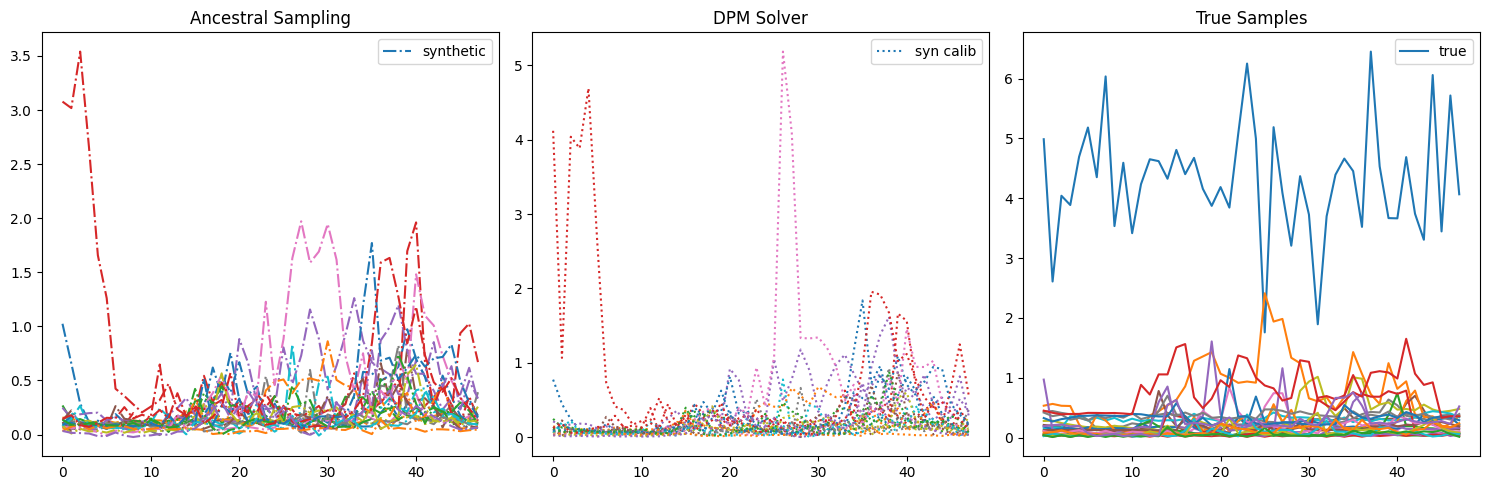

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx in range(min(synthetic.shape[0], 25)):
    axs[0].plot(synthetic[idx].detach().cpu().numpy(), linestyle='-.', label="synthetic" if idx == 0 else None)
axs[0].set_title('Ancestral Sampling')
axs[0].legend()

for idx in range(min(syn_calib.shape[0], 25)):
    axs[1].plot(syn_calib[idx].detach().cpu().numpy(), linestyle=':', label="syn calib" if idx == 0 else None)
axs[1].set_title('DPM Solver')
axs[1].legend()

for idx in range(min(real_kwh.shape[0], 25)):
    axs[2].plot(real_kwh[idx].detach().cpu().numpy(), label="true" if idx == 0 else None)
axs[2].set_title('True Samples')
axs[2].legend()

plt.tight_layout()
plt.show()
pass

In [17]:
def plot_stats(real_kwh, synthetic):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(synthetic.mean(dim=0).detach().numpy(), label="synthetic kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(synthetic.quantile(0.95, dim=0).detach().numpy(), label="synthetic kwh")
    ax2.set_title("95th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("Median kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(synthetic.quantile(0.5, dim=0).detach().numpy(), label="synthetic kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

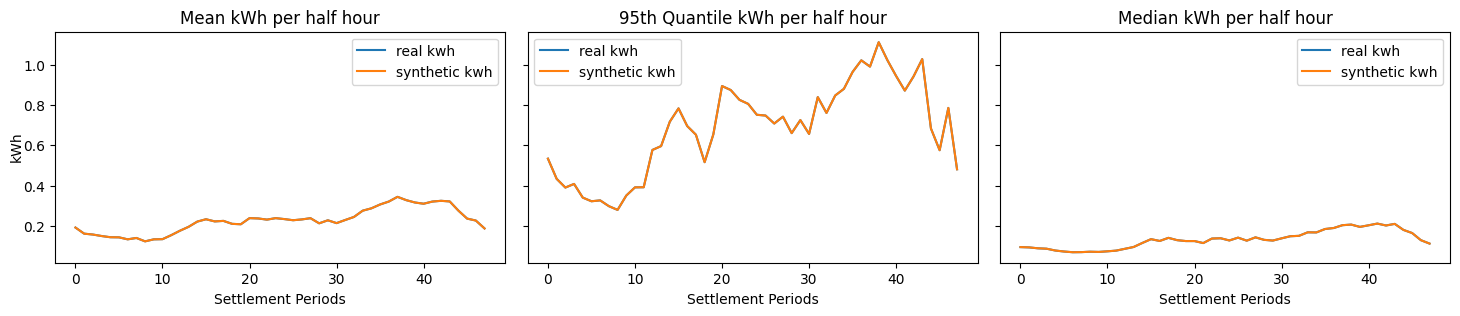

In [18]:
plot_stats(real_kwh, syn_calib)

In [19]:
def plot_more_quantiles(real_kwh, synthetic):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(synthetic.mean(dim=0).detach().numpy(), label="synthetic kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.70, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(synthetic.quantile(0.70, dim=0).detach().numpy(), label="synthetic kwh")
    ax2.set_title("70th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.99, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("99th Quantile kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(synthetic.quantile(0.99, dim=0).detach().numpy(), label="synthetic kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

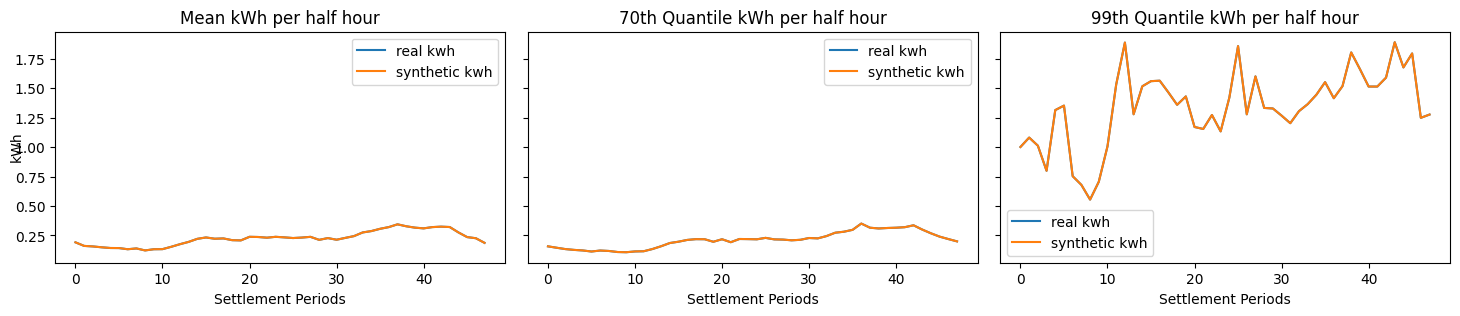

In [20]:
plot_more_quantiles(real_kwh, syn_calib)

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


def train_pca_and_tsne(real_kwh, gmm_reconstruct):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    pca.fit(real_kwh.detach().numpy())
    pca_real = pca.transform(real_kwh.detach().numpy())
    pca_gmm = pca.transform(gmm_reconstruct.detach().numpy())

    tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_reconstruct.detach().numpy()])
    tsne_results = tsne.fit_transform(tsne_input)
    tsne_real = tsne_results[:len(real_kwh)]
    tsne_gmm = tsne_results[len(real_kwh):]

    return pca_real, pca_gmm, tsne_real, tsne_gmm


def plot_pca_tsne(pca_real, pca_gmm, tsne_real, tsne_gmm):
    fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

    ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_pca.set_title("PCA")
    ax_pca.set_xlabel("PCA 1")
    ax_pca.set_ylabel("PCA 2")
    ax_pca.legend()

    ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_tsne.set_title("TSNE")
    ax_tsne.set_xlabel("TSNE 1")
    ax_tsne.set_ylabel("TSNE 2")
    ax_tsne.legend()
    return fig


Text(0.5, 1.0, 'synthetic data vs real')

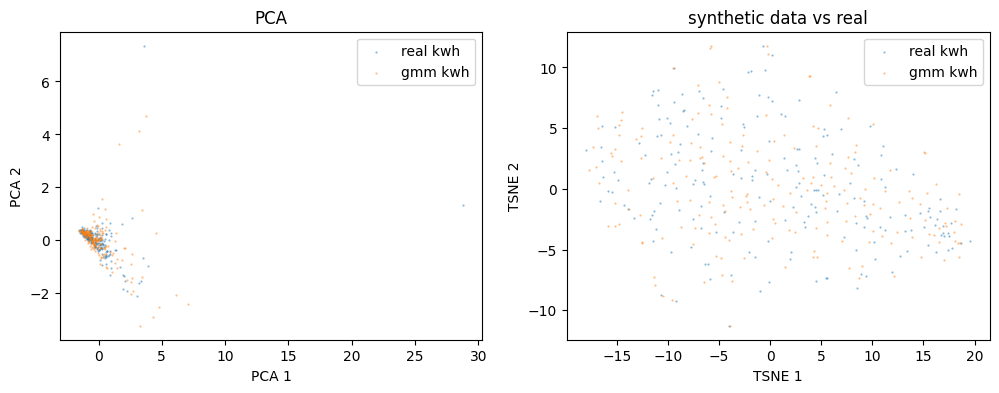

In [22]:
a1, a2, a3, a4 = train_pca_and_tsne(real_kwh, syn_calib)
_ = plot_pca_tsne(a1, a2, a3, a4)
plt.title("synthetic data vs real")